# Using Agglomerative Clustering to Segment Prices

In [1]:
# Libraries
import pandas as pd
from scipy.stats import boxcox
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get some data on game sales to play with
# (if this doesn't work, use `games.csv`)
df = pd.read_html(
    'http://garaph.info/sqldirect.php?queryid=3312',
    header = 0, index_col = 0
)[0]

# Convert to USD (roughly)
df['LaunchPrice'] /= 100
df['TotalSales'] *= df.LaunchPrice

# Rename the columns to match the names
# used in the original application
df.columns = ['NAME','UNITCOST','REV']

In [3]:
# Take a look at where the outliers might be
μ, σ = df.UNITCOST.mean(), df.UNITCOST.std()
iqr = list(df.UNITCOST.describe(
    percentiles = [.25, .75]
))[-4:-1]

print('Non-outliers')
print('------------------------------')
print('       μ ± 3σ: %.2f to %.2f' % (
    μ - 3*σ, μ + 3*σ
))
print('IQR criterion: %.2f to %.2f' % (
    iqr[0] - 1.5*(iqr[2] - iqr[0]), 
    iqr[2] + 1.5*(iqr[2] - iqr[0])
))

Non-outliers
------------------------------
       μ ± 3σ: 16.16 to 102.49
IQR criterion: 18.90 to 102.90


In [4]:
# Cut off anything above 120 USD
df = df[df.UNITCOST <= 120]

In [5]:
# Scoring function -- KMeans has built-in scoring, but 
# we must define our own for AgglomerativeClustering
def score(data, clusters):
    distsum = 0
    for c in set(clusters):
        distsum += sum(abs(
            data[clusters == c] 
            - data[clusters == c].mean()
        ))
    return distsum / len(data)

In [6]:
# Find the best λ value for Box-Cox transformation
df['X'], λ = boxcox(df.UNITCOST)

In [7]:
# For convenience, define transformation and inverse
def bc(x):
    return (x**λ - 1)/λ if λ != 0 else np.log(x)

def ibc(x):
    if λ == 0:
        return np.exp(x)
    if x*λ + 1 < 0: 
        return None
    return (x*λ + 1)**(1/λ)

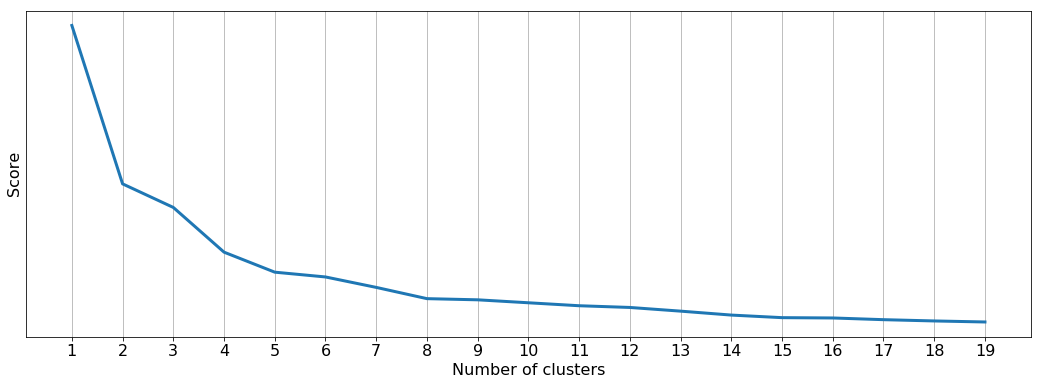

In [8]:
# Try variety of cluster numbers, graph the scores
score_x = []
score_y = []
for nc in range(1, 20):
    ac = AgglomerativeClustering(nc)
    ac.fit(df.X.values.reshape(-1, 1))
    score_x.append(nc)
    score_y.append(score(df.X, ac.labels_))
    
plt.rcParams['figure.figsize'] = 18, 6
plt.rcParams['font.size'] = 16

plt.plot(score_x, score_y, lw = 3)
plt.xticks(score_x)
plt.yticks([])
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.grid()
plt.show()

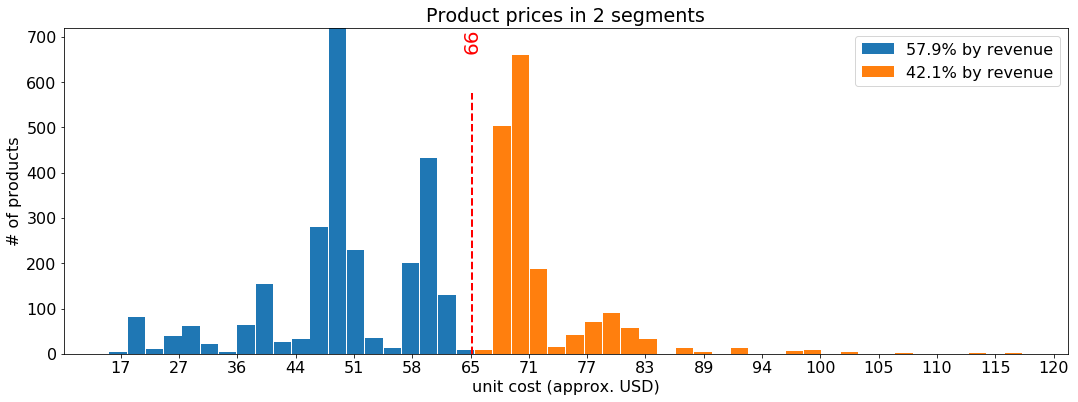

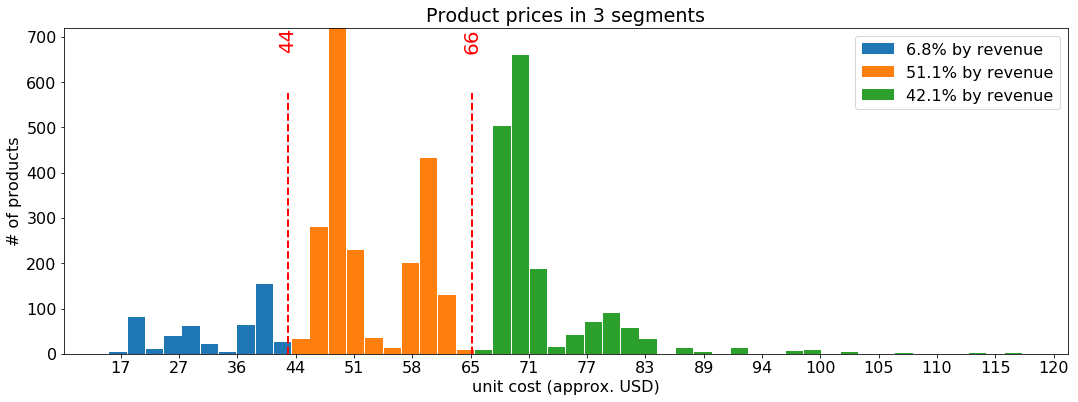

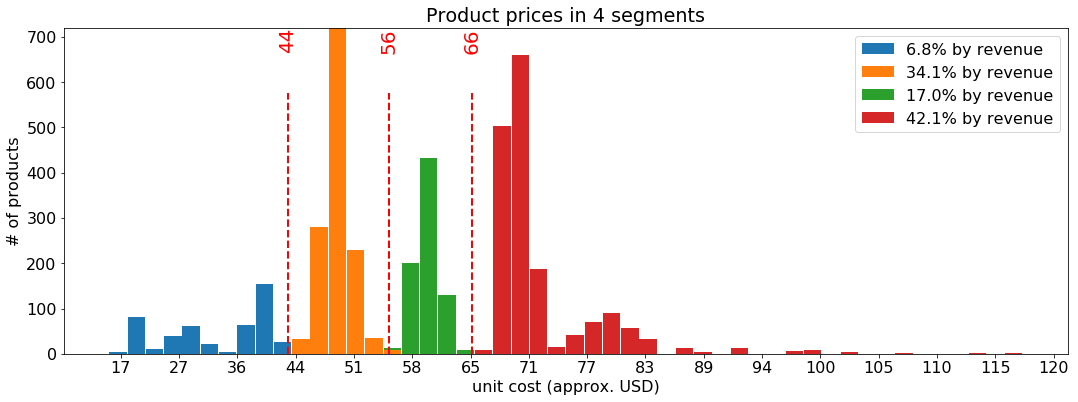

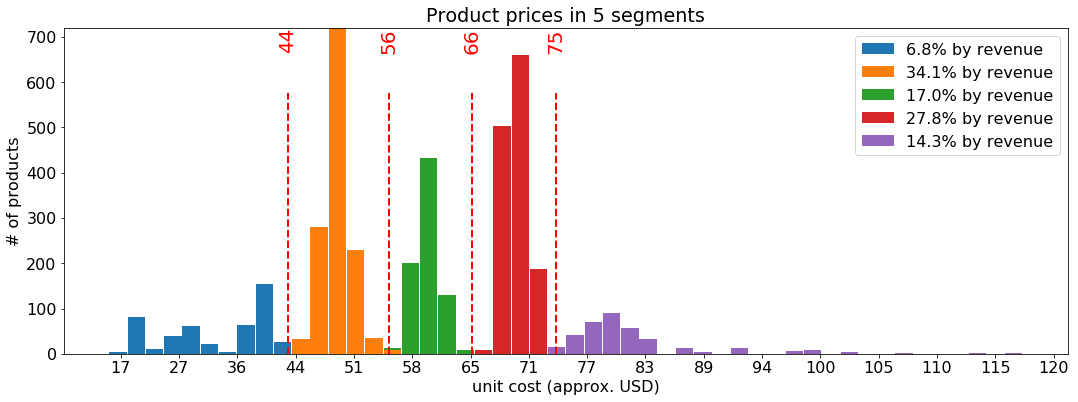

In [9]:
# Take closer look at results for 2-5 clusters
for nc in [2,3,4,5]:
    ac = AgglomerativeClustering(nc).fit(
        df.X.values.reshape(-1, 1)
    )
    df['cluster'] = ac.labels_

    # Find the boundaries between the clusters
    cdf = df.drop(['X','REV'], 1).groupby(
        'cluster'
    ).describe()
    cdf.columns = [c[1] for c in cdf.columns]
    bounds = (
        (cdf.sort_values('mean')['max'].values[:-1] 
        + cdf.sort_values('mean')['min'].values[1:]) / 2
    )

    # Re-number the clusters in logical order
    df['cluster'] = df.cluster.replace({
        r[1].cluster : r[0]
        for r in
        cdf.sort_values('mean').reset_index().iterrows()
    })

    # Build special dataframe for visualizing price bins
    dfdict = {}
    for c in set(df.cluster):
        dfdict['cluster%d' % c] = df[df.cluster == c].X

    # Visualize the price bins
    pd.DataFrame(dfdict).plot.hist(
        stacked = True, bins = 50, 
        rwidth = .95, legend = False
    )
    xt = plt.gca().get_xticks()
    xt = np.linspace(min(xt), max(xt) + 1, 20)
    xt = [x for x in xt if type(ibc(x)) == np.float64]
    plt.xticks(xt, [int(ibc(x)) for x in xt])
    plt.xlabel('unit cost (approx. USD)')
    plt.ylabel('# of products')

    # Make a legend with the revenue shares
    plt.legend([
        '%.1f%% by revenue' % (r*100) for r in
        df.groupby('cluster').agg({
            'UNITCOST' : 'median',
            'REV' : 'sum'
        }).REV / df.REV.sum()
    ])    

    # Show the boundaries
    ytop = plt.gca().get_ylim()[-1]
    for b in bounds:
        plt.plot(
            [bc(b), bc(b)],
            [0, .8*ytop],
            'r--', lw = 2
        )
        plt.text(
            bc(b), ytop, '%.0f' % b, rotation = 90, 
            fontdict = {
                'color' : 'red', 'size' : 20,
                'va' : 'top', 'ha' : 'center'
            }
        )
        
    plt.title('Product prices in %d segments' % nc)
    plt.show()
    